Muhammad Kevin Mahendra Caropeboka

MSIB Bisa AI - AI Hacker

In [11]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import os
from os import walk
import matplotlib.pyplot as plt
import random
from skimage.transform import resize 
from tensorflow.keras import utils 
from scipy.ndimage import rotate
import gc

from sklearn.metrics import confusion_matrix 

In [12]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

NameError: name 'tf' is not defined

In [14]:
PATH = '../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset'
TARGET_HEIGHT = 102
TARGET_WIDTH = 136
TEST_RATIO = 0.2
VAL_RATIO = 0.2
random.seed(42)

In [15]:
#read .jpg files to list of arrays

labels = []
X_all = []
y_all = []

for dir in tqdm([f.path for f in os.scandir(PATH) if f.is_dir()]):
    labels.append(dir.split('/')[-1])
    for file in next(walk(dir), (None, None, []))[2]:
        if file != ".ipynb_checkpoints":
            file_path = os.path.join(dir, file)
            img = cv2.imread(file_path)
            img_array = np.asarray(img)
            X_all.append(img_array)
            y_all.append(dir.split('/')[-1])

100%|██████████| 3/3 [01:22<00:00, 27.44s/it]


In [16]:
# transform label to digit

y_out = []

for i, label in enumerate(y_all):
    y_out.append(labels.index(label))

y_all = y_out

In [17]:
### Shuffle samples and labels together, divide into test, validation, and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

num_samples = len(X_all)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)
num_samples_val = int(VAL_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The next `num_samples_val` samples of the shuffled list becomes the validation set
X_val = X_all[num_samples_test:(num_samples_test + num_samples_val)]
y_val = y_all[num_samples_test:(num_samples_test + num_samples_val)]

# The remaining samples become the training set
X_train = X_all[(num_samples_test + num_samples_val):]
y_train = y_all[(num_samples_test + num_samples_val):]

del X_all, y_all
gc.collect()

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test, validation, and training samples
print("Number of test samples:", num_samples_test)
print("Number of validation samples:", num_samples_val)
print("Number of training samples:", num_samples_train)

Number of test samples: 3000
Number of validation samples: 3000
Number of training samples: 9000


In [18]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
    X_out = []
    for i, img in enumerate(images):
        X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
    return X_out

In [19]:
# Resize (scale) all images in the train set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the validation set
X_val = resize_images(X_val, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)

In [20]:
### Convert list of samples and labels into Numpy arrays

# Training set
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Validation set
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

# Test set
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Training y:", y_train.shape)
print("Validation X:", X_val.shape)
print("Validation y:", y_val.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Training X: (9000, 102, 136, 3)
Training y: (9000,)
Validation X: (3000, 102, 136, 3)
Validation y: (3000,)
Test X: (3000, 102, 136, 3)
Test y: (3000,)


In [21]:
num_classes = len(labels)

# Use Keras's np_utils to create one-hot encoding (note the capital 'Y' - 2D array)
Y_train = utils.to_categorical(y_train, num_classes)
Y_val = utils.to_categorical(y_val, num_classes)
Y_test = utils.to_categorical(y_test, num_classes)

# Print out shapes (capital 'Y' is our one-hot matrix!)
print("Y train:", Y_train.shape)
print("Y val:", Y_val.shape)
print("Y test:", Y_test.shape)

# Print out a few examples from training set
for i in range(10):
    print("Label: " + str(y_train[i]) + " | One-hot:", Y_train[i])

Y train: (9000, 3)
Y val: (3000, 3)
Y test: (3000, 3)
Label: 1 | One-hot: [0. 1. 0.]
Label: 2 | One-hot: [0. 0. 1.]
Label: 1 | One-hot: [0. 1. 0.]
Label: 1 | One-hot: [0. 1. 0.]
Label: 0 | One-hot: [1. 0. 0.]
Label: 1 | One-hot: [0. 1. 0.]
Label: 2 | One-hot: [0. 0. 1.]
Label: 0 | One-hot: [1. 0. 0.]
Label: 1 | One-hot: [0. 1. 0.]
Label: 0 | One-hot: [1. 0. 0.]


In [22]:
#functions for data augmentation
def translate(img, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img


def random_crop(img, crop_size=(70, 70)):
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w, h = img.shape[:2]
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img = img[y:y+crop_size[0], x:x+crop_size[1]]
    return img


def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

In [23]:
#add more data to train set
def add_augment_data(X_train, Y_train, y_train):
    
    idx = random.sample(range(0, X_train.shape[0]), 300)
    
    for i in tqdm(idx):
        img_lst = []
        y_lst = []
        #img_lst.append(translate(X_val[i], direction='right'))
        #img_lst.append(translate(X_val[i], direction='left'))
        img_lst.append(translate(X_train[i], direction='down'))
        img_lst.append(translate(X_train[i], direction='up'))
        #img_lst.append(resize(random_crop(X_val[i]), (height, width), anti_aliasing=anti_aliasing))
        #img_lst.append(rotate_img(X_val[i], angle=90))
        img_lst.append(gaussian_noise(X_train[i]))
        img_arr = np.asarray(img_lst)
        y_arr = utils.to_categorical(np.asarray([y_train[i] for _ in range(img_arr.shape[0])]), num_classes)
        X_train = np.concatenate((X_train,img_arr))
        Y_train = np.concatenate((Y_train, y_arr))

    X_y = list(zip(X_train, Y_train))
    random.shuffle(X_y)
    X, y = zip(*X_y)
    
    return X, y
    
    
        
        
        
        
        
    

In [24]:
X_train, Y_train = add_augment_data(X_train, Y_train, y_train)
len(X_train), len(Y_train)

100%|██████████| 300/300 [06:00<00:00,  1.20s/it]


(9900, 9900)

In [25]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [26]:
from tensorflow.keras.models import Sequential           
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Activation, Flatten

In [27]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (TARGET_HEIGHT, TARGET_WIDTH, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

2022-11-02 12:55:16.223953: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 136, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 102, 136, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 68, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 51, 68, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 68, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 68, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 34, 64)        0

In [28]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=64, 
                    epochs=10, 
                    verbose=1,
                    validation_data=(X_val, Y_val))

2022-11-02 12:55:20.154547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
155/155 [==============================] - 389s 3s/step - loss: 0.6841 - acc: 0.7327 - val_loss: 0.2757 - val_acc: 0.9010
Epoch 2/10
155/155 [==============================] - 384s 2s/step - loss: 0.2845 - acc: 0.8931 - val_loss: 0.1957 - val_acc: 0.9247
Epoch 3/10
155/155 [==============================] - 383s 2s/step - loss: 0.2013 - acc: 0.9287 - val_loss: 0.1367 - val_acc: 0.9497
Epoch 4/10
155/155 [==============================] - 378s 2s/step - loss: 0.1529 - acc: 0.9481 - val_loss: 0.1148 - val_acc: 0.9580
Epoch 5/10
155/155 [==============================] - 377s 2s/step - loss: 0.1158 - acc: 0.9589 - val_loss: 0.1263 - val_acc: 0.9570
Epoch 6/10
155/155 [==============================] - 378s 2s/step - loss: 0.0938 - acc: 0.9680 - val_loss: 0.0915 - val_acc: 0.9690
Epoch 7/10
155/155 [==============================] - 376s 2s/step - loss: 0.0774 - acc: 0.9741 - val_loss: 0.0917 - val_acc: 0.9710
Epoch 8/10
155/155 [==============================] - 376s 2s/step - 

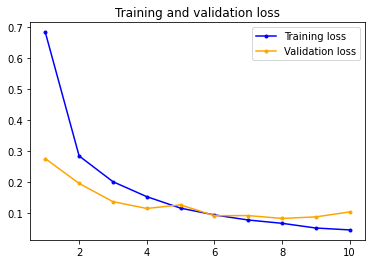

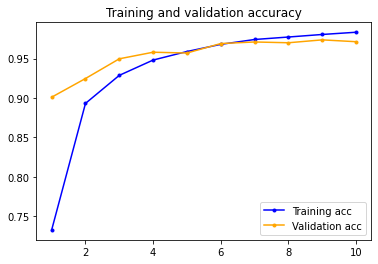

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [30]:
### Evaluate model on validation set
score = model.evaluate(X_val, Y_val)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

94/94 [==============================] - 27s 291ms/step - loss: 0.1036 - acc: 0.9713
Validation loss: 0.10361755639314651
Validation accuracy: 0.9713333249092102


In [31]:
### Try predicting label with one validation sample (inference)

# Change this to try a different sample from the test set
idx = 2

# Make sample 2D array instead of 1D vector (this is what the Keras model expects as input)
x = np.expand_dims(X_val[idx], 0)
print(x.shape)

# Make prediction using trained model
y_pred = model.predict(x)

# Find index of highest score in output
predicted_label = np.argmax(y_pred)
actual_label = np.argmax(Y_val[idx])

# Display model output, predicted label, actual label
print("Model output:", y_pred)
print("Predicted label:", predicted_label, "-", labels[predicted_label])
print("Actual label:", actual_label, "-", labels[actual_label])

(1, 102, 136, 3)
Model output: [[9.9780947e-01 2.1906050e-03 1.0696659e-09]]
Predicted label: 0 - Shoe
Actual label: 0 - Shoe


In [32]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
Y_pred = model.predict(X_val)
print("Validation output shape:", Y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val = np.argmax(Y_val, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val[:50])
print("Predicted validation labels:\t", y_pred[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val, y_pred)
cm = np.transpose(cm)

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
    print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))

Validation output shape: (3000, 3)
Actual validation labels:	 [1 1 0 2 2 1 2 2 0 1 0 0 1 2 1 2 0 2 0 2 0 1 1 1 1 2 1 2 0 0 2 1 0 1 2 1 1
 2 2 1 1 0 0 2 1 2 1 0 1 0]
Predicted validation labels:	 [1 1 0 2 2 1 2 2 0 1 0 0 1 2 1 2 0 2 0 2 2 1 1 1 1 2 1 2 0 0 2 1 0 1 2 1 1
 2 2 1 1 0 0 2 1 2 1 0 1 0]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)   
        Shoe (0):  [   980     19      3]
      Sandal (1):  [    19    949      8]
        Boot (2):  [    21     16    985]


In [33]:
#find misclassified indices and add them to list
def find_mismatch(lst1, lst2):
    idx = 0
    res = []

    for i in lst1:
        if i != lst2[idx]:
            res.append(idx)
        idx = idx + 1
    return res


In [34]:
idx_lst = find_mismatch(y_val, y_pred)
len(idx_lst)

86

In [35]:
### Evaluate model on test set
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

94/94 [==============================] - 27s 287ms/step - loss: 0.1099 - acc: 0.9727
Test loss: 0.10990690439939499
Test accuracy: 0.9726666808128357
